## 5.2 LSTM

Why add LSTM model?

Cause ARIMA model in the before part is a single variable time series prediction model. And what we need to predict is the event column which only have two numbers (0 and 1). So the ARIMA model performs very well (MSE almost to 0) but I think it doesn't mean something (it is very easy to predict a line with 1 from several 0s and 1s).

That's why I add LSTM model, it is also one time series forecasting model and can use several other features to predict one target feature future values.

But it needs a lot of arithmetic, so I used kaggle's notebook, two gpu's to run the LSTM model.

Wish the result is better!


In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
all_data_LSTM = pd.read_parquet('/kaggle/input/data-lstm')

In [3]:
all_data_sorted_LSTM = all_data_LSTM.sort_values(by=['series_id', 'step'])

all_data_sorted_LSTM.head()

,series_id,step,timestamp,anglez,enmo,hour,event,night,sleep_duration,anglez_diff,...,enmo_rolling_mean,anglez_rolling_max,enmo_rolling_max,anglez_rolling_std,enmo_rolling_std,anglez_diff_rolling_mean,enmo_diff_rolling_mean,anglez_diff_rolling_max,enmo_diff_rolling_max,enmo_rolling_skew
0,0,0,2018-11-05 10:00:00,30.845301,0.0447,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
1,0,1,2018-11-05 10:00:05,34.181801,0.0443,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
2,0,2,2018-11-05 10:00:10,33.877102,0.0483,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
3,0,3,2018-11-05 10:00:15,34.282101,0.0680,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
4,0,4,2018-11-05 10:00:20,34.385799,0.0768,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953


In [4]:
min_missing_ratio_LSTM = float('inf')
series_id_with_min_missing_ratio_LSTM = None

for series_id in all_data_sorted_LSTM['series_id'].unique():
    series_data_LSTM = all_data_sorted_LSTM[all_data_sorted_LSTM['series_id'] == series_id]
    series_data_LSTM = series_data_LSTM.sort_values(by='step') 

    total_steps_LSTM = len(series_data_LSTM)

    step_diff_LSTM = series_data_LSTM['step'].diff() - 1
    missing_steps_count_LSTM = step_diff_LSTM[step_diff_LSTM > 0].sum()

    missing_ratio_LSTM = missing_steps_count_LSTM / total_steps_LSTM if total_steps_LSTM > 0 else 0

    if missing_ratio_LSTM < min_missing_ratio_LSTM:
        min_missing_ratio_LSTM = missing_ratio_LSTM
        series_id_with_min_missing_ratio_LSTM = series_id
        
print(f"The series_id with the smallest percentage of total step is {series_id_with_min_missing_ratio_LSTM}, missing ratio is {min_missing_ratio_LSTM:.2%}")


The series_id with the smallest percentage of total step is 0, missing ratio is 0.00%


In [5]:
all_data_sorted_LSTM[all_data_sorted_LSTM['series_id'] == 0]['event'].value_counts()

event
1.0    303384
0.0    136896
Name: count, dtype: int64

In [6]:
all_data_sorted_LSTM[all_data_sorted_LSTM['series_id'] == 0].tail(1)['step']

440279    440279
Name: step, dtype: uint32

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, BatchNormalization, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Setting the timestamp column as a time series index
if 'timestamp' in all_data_sorted_LSTM.columns:
    all_data_sorted_LSTM = all_data_sorted_LSTM.set_index('timestamp')

# choose series_id = 0 to analyze
selected_series_id_LSTM = all_data_sorted_LSTM[all_data_sorted_LSTM['series_id'] == 0]

Epoch 1/100
9631/9631 - 72s - loss: 0.0616 - val_loss: 0.2328 - 72s/epoch - 7ms/step
Epoch 2/100
9631/9631 - 60s - loss: 0.0221 - val_loss: 0.5076 - 60s/epoch - 6ms/step
Epoch 3/100
9631/9631 - 60s - loss: 0.0162 - val_loss: 0.5763 - 60s/epoch - 6ms/step
Epoch 4/100
9631/9631 - 60s - loss: 0.0140 - val_loss: 0.5976 - 60s/epoch - 6ms/step
Epoch 5/100
9631/9631 - 59s - loss: 0.0117 - val_loss: 0.7358 - 59s/epoch - 6ms/step
Epoch 6/100
9631/9631 - 58s - loss: 0.0099 - val_loss: 0.7658 - 58s/epoch - 6ms/step
Epoch 7/100
9631/9631 - 58s - loss: 0.0091 - val_loss: 0.8093 - 58s/epoch - 6ms/step
Epoch 8/100
9631/9631 - 59s - loss: 0.0080 - val_loss: 0.8414 - 59s/epoch - 6ms/step
Epoch 9/100
9631/9631 - 59s - loss: 0.0076 - val_loss: 0.7858 - 59s/epoch - 6ms/step
Epoch 10/100
9631/9631 - 59s - loss: 0.0072 - val_loss: 0.7779 - 59s/epoch - 6ms/step
Epoch 11/100
9631/9631 - 60s - loss: 0.0071 - val_loss: 0.8571 - 60s/epoch - 6ms/step
4128/4128 [==============================] - 12s 3ms/step


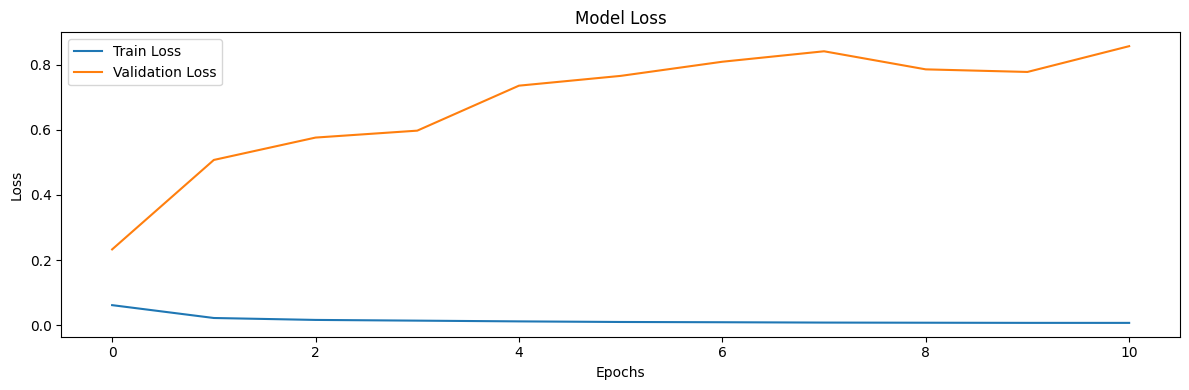

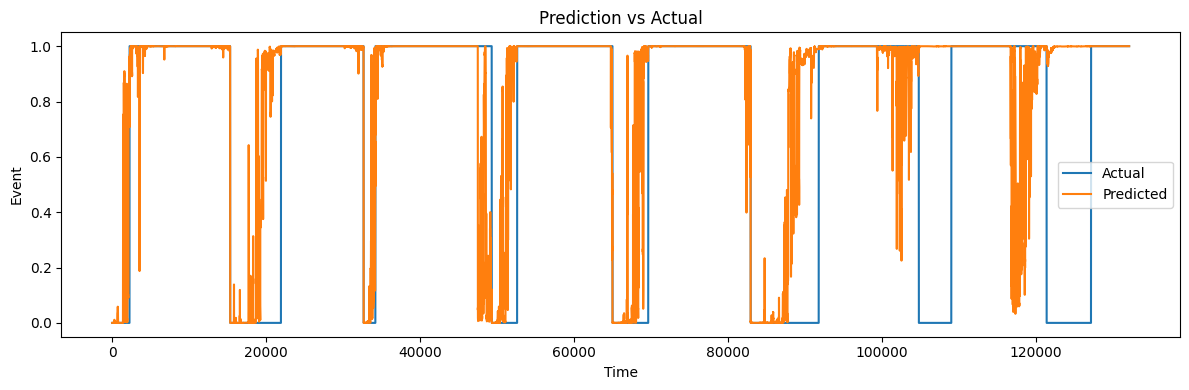

In [10]:
# Scaling features except 'event' column
features = selected_series_id_LSTM.drop(['event'], axis=1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scaling 'event' column separately - assuming it's a binary classification problem
target = selected_series_id_LSTM['event'].values.reshape(-1, 1)

# Creating dataset function
def create_dataset(features, target, look_back=1):
    X, Y = [], []
    for i in range(len(features) - look_back):
        X.append(features[i:(i + look_back), :])
        Y.append(target[i + look_back])
    return np.array(X), np.array(Y)

look_back = 5
X, Y = create_dataset(scaled_features, target, look_back)

# Splitting dataset
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# LSTM model construction
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))  
model.compile(optimizer='adam', loss='binary_crossentropy')  

# Early stopping setup
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model and saving the training history
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, 
                    validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Predicting
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Visualizing the model's loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Visualizing predictions vs actual values
plt.figure(figsize=(12, 4))
plt.plot(Y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Event')
plt.legend()
plt.tight_layout()
plt.show()

I think the result for LSTM is not bad and the beginning prediction is good. But the prediction for the last part is not good. I think it is because the data is not enough for the LSTM model to learn. So I think if we have more data, the result will be better.

1. Model Loss Graph Analysis:

The first graph depicts the model's training loss (blue) and validation loss (orange) across epochs.

The training loss decreases steadily, which indicates that the model is learning from the training data.

The validation loss, however, starts to increase after a certain point, suggesting that the model might be overfitting to the training data. Overfitting is when a model learns patterns that are specific to the training data, which do not generalize well to new, unseen data. We want to avoid overfitting as much as possible, so that our model can accurately predict unseen data. Our future work is to introduce adaptive mechanisms that reduce the errors generated by predictions of larger and more distant future times.

2. Prediction vs. Actual Graph Analysis:

The second graph compares the actual values (blue) to the predicted values (orange) of the event column over time.

The actual values show a clear binary pattern, which aligns with your description that the event column represents two states (e.g., awake and asleep).

The predicted values appear to follow the actual pattern closely, but there are instances where the predictions do not match the actual values (e.g., false positives or false negatives).

The prediction graph shows some noise, especially in the transitions between 0 and 1. It might benefit from additional post-processing like thresholding to clean up the predictions.
